### 0. Install necessary packages

In [1]:
from preprocessing import Preprocess
from models import OgModel, AttModel
from evaluation import EvaluateModel

2024-12-07 20:16:13.624381: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-07 20:16:13.625045: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-07 20:16:13.627507: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-07 20:16:13.633553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733598973.644290   86483 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733598973.64

### 1. Load the data

In [2]:
X_train, y_train, X_val, y_val, X_test, y_test, m, s = Preprocess(time_steps=5, start_year=2000, save=False)

--- Preprocessing ---
Remove low yield observations:  2
of years:  [1988. 2003.]
Full train data available:  (24311, 393)
Train data used: (10707, 397), starting from year 2000.
- Preprocessed data -
Train data (10707, 397, 1)
Validation data (560, 397, 1)
Test data (472, 397, 1)
Test data has mean 1.5 and std 0.99.



### 2. Set hyperparameters

In [3]:
Max_it = 4
learning_rate = 0.0006        # Learning rate

# Loss function parameters
alpha = 1                     # Weight of loss for final time step
beta = 1                      # Weight of loss for years before final time steps

# LSTM parameters
time_steps = 5                # Number of time steps for the RNN
num_units = 64                # Number of hidden units for LSTM cells
num_layers = 2                # Number of layers of LSTM cell
dropout = 0.3                 # Dropout rate

# Attention parameters
num_heads = 4
key_dim = 32

### 3.1 Original Model

In [4]:
ogmodel = OgModel(learning_rate, alpha, beta, time_steps, num_units, num_layers, dropout)
ogmodel.compile()

W0000 00:00:1733598975.497494   86483 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...



--- Model Architecture ---
 - CNN for Weather data - 
Output W-CNN: (None, 66)
 - CNN for Soil data - 
Output S-CNN: (None, 44)
 - Concatenate weather, soil and management data - 
W+S+M concatenated: (None, 124)
W+S+M after Dense: (None, 64)
 - LSTM for yield data - 
LSTM output: (None, 64)
 - Combine static and dynamic features - 
Combined: (None, 128)
Combined Dense: (None, 16)
Output: (None, 1) 

Total parameters: 112659


<Functional name=functional_17, built=True>

In [5]:
ogmodel.fit(X_train, y_train, X_val, y_val, epochs=3)

Epoch 1/3
335/335 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 1.1184 - val_loss: 0.3960 - learning_rate: 6.0000e-04
Epoch 2/3
335/335 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.3103 - val_loss: 0.2426 - learning_rate: 6.0000e-04
Epoch 3/3
335/335 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2110 - val_loss: 0.1890 - learning_rate: 6.0000e-04


<Functional name=functional_17, built=True>

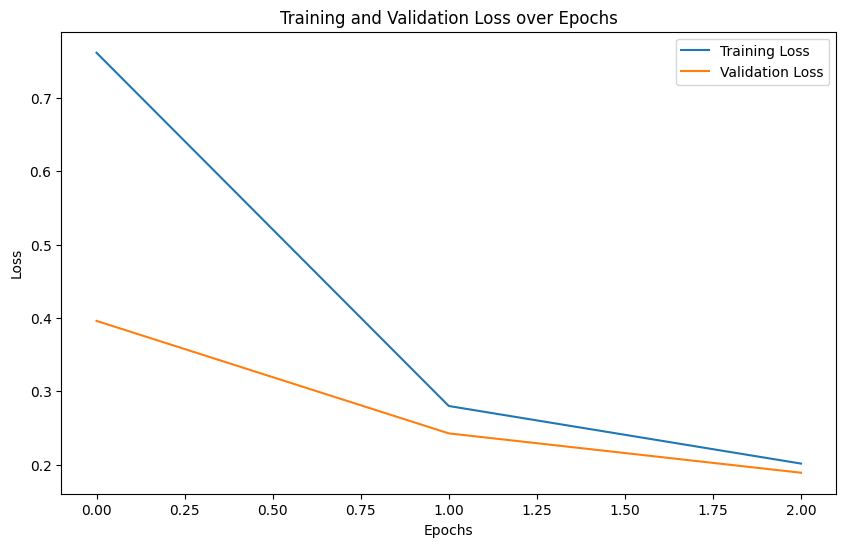

In [6]:
ogmodel.plot_training_history()

335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training RMSE: 4.896631943150446
Validation RMSE: 5.171967242447195 

Training MAE: 3.6562660641402047
Validation MAE: 3.905536990181723 

Training R²: 0.7979379759373934
Validation R²: 0.6975559347864744


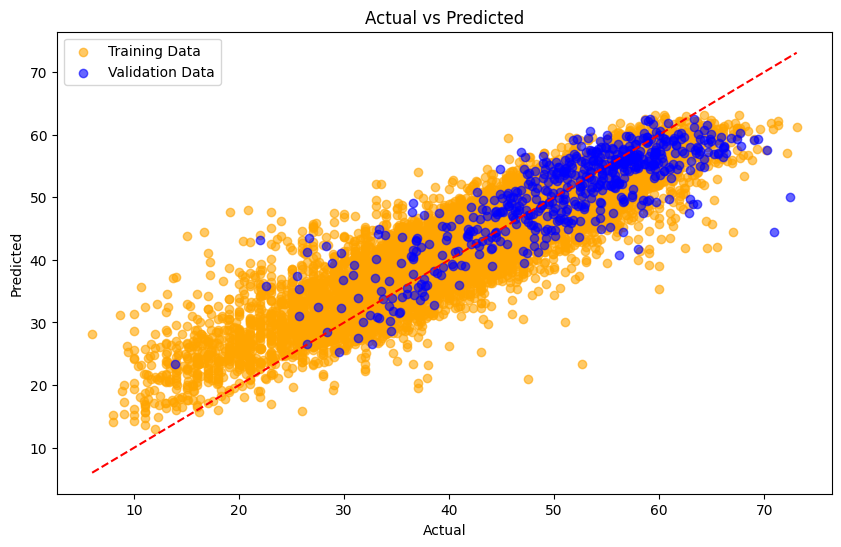

In [7]:
og_evaluator = EvaluateModel(ogmodel, X_train, y_train, X_val, y_val, s, m)
og_evaluator.evaluate()

### 3.2 Attention Model

In [8]:
attmodel = AttModel(learning_rate, alpha, beta, time_steps, num_units, num_layers, dropout, num_heads, key_dim)
attmodel.compile()


--- Model Architecture ---
 - CNN for Weather data - 
Input: (None, 52, 1)
Output: (None, 66)
 - CNN for Soil data - 
Input: (None, 6, 1)
Output: (None, 44)
 - Concatenate weather, soil and management data - 
W+S+M concatenated: (None, 124)
W+S+M after Dense: (None, 64)
 - LSTM for yield data - 
LSTM output: (None, 64)
 - Combine static and dynamic features - 
Combined: (None, 128)
Combined Dense: (None, 16)
Output: (None, 1) 

Total parameters: 113556


<Functional name=functional_35, built=True>

In [9]:
attmodel.fit(X_train, y_train, X_val, y_val, epochs=3)

Epoch 1/3
335/335 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 1.0867 - val_loss: 0.4953 - learning_rate: 6.0000e-04
Epoch 2/3
335/335 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.2988 - val_loss: 0.3251 - learning_rate: 6.0000e-04
Epoch 3/3
335/335 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.2074 - val_loss: 0.2977 - learning_rate: 6.0000e-04


<Functional name=functional_35, built=True>

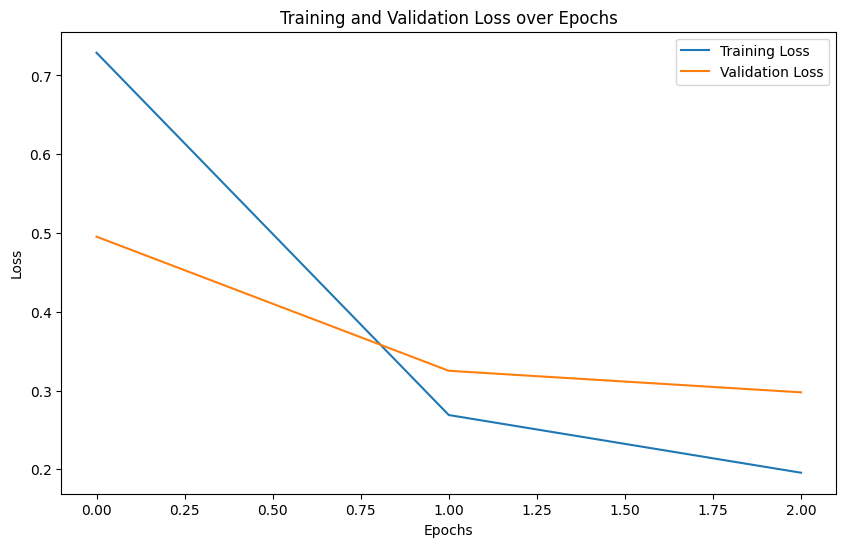

In [10]:
attmodel.plot_training_history()

335/335 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


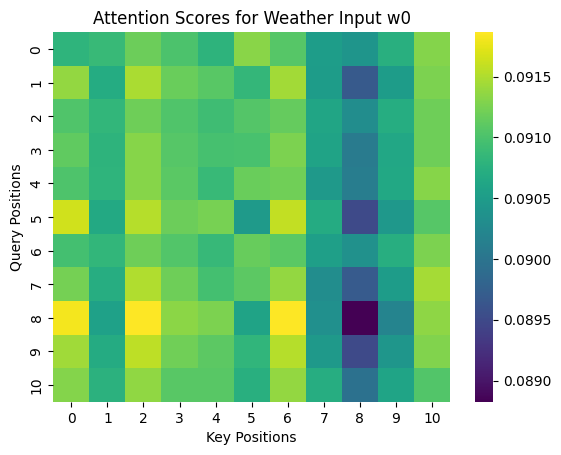

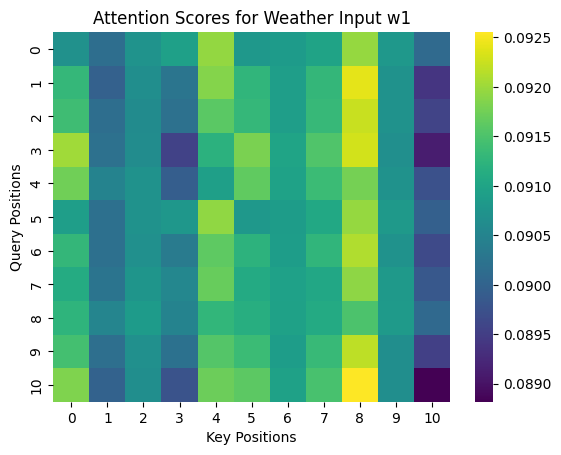

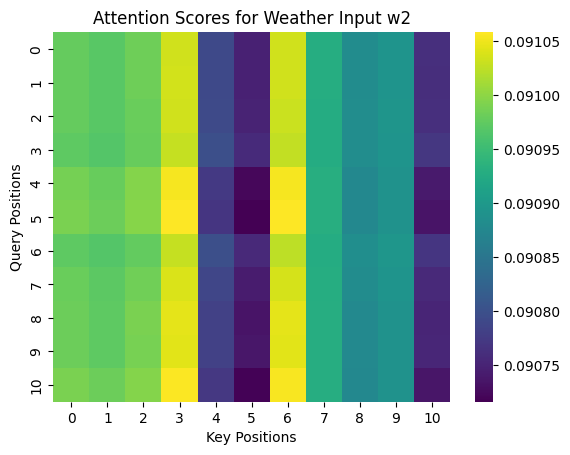

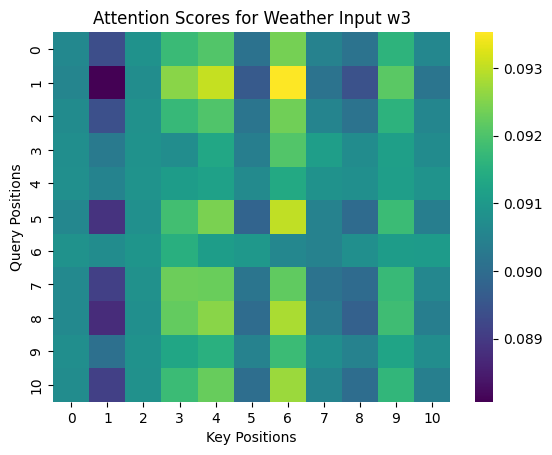

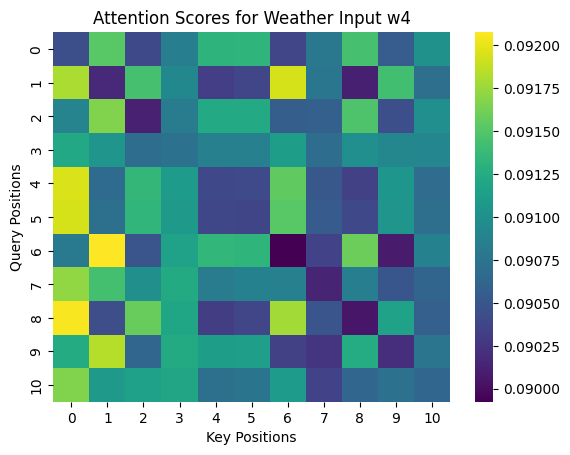

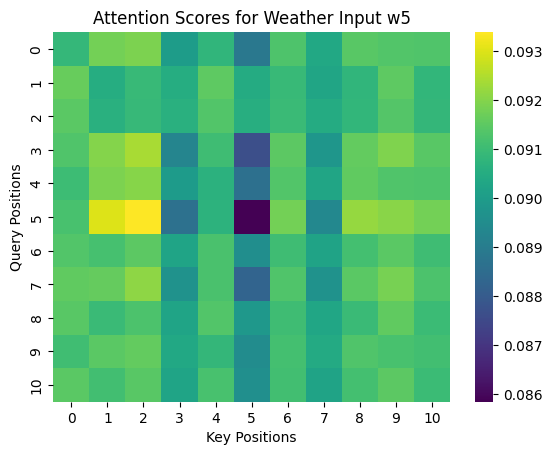

In [11]:
attmodel.visualize_attention(X_train, 'weather')

335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Training RMSE: 4.7623988948427
Validation RMSE: 7.264384194381387 

Training MAE: 3.5973155035258557
Validation MAE: 6.0124851711954275 

Training R²: 0.808864518998723
Validation R²: 0.4033341999900888


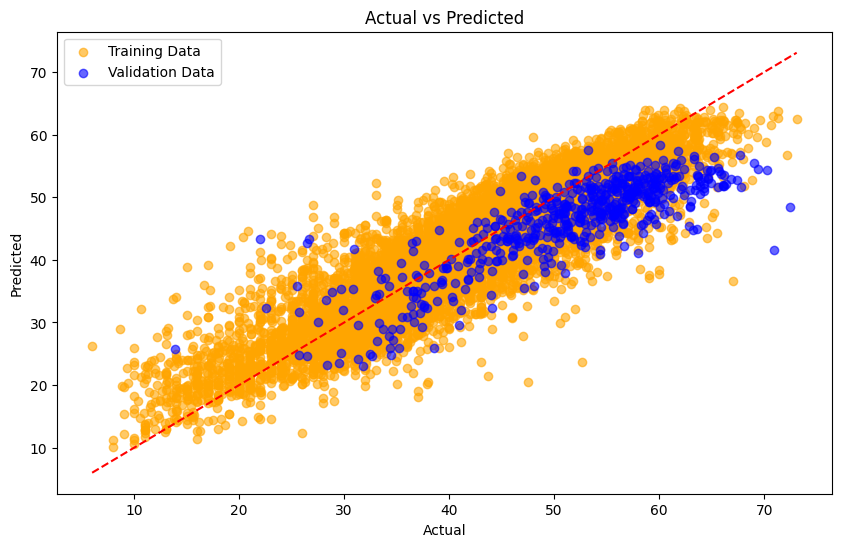

In [12]:
att_evaluator = EvaluateModel(attmodel, X_train, y_train, X_val, y_val, s, m)
att_evaluator.evaluate()

### 4. Explainability

In [13]:
import shap
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_val)
shap.summary_plot(shap_values, X_val)

ModuleNotFoundError: No module named 'shap'